In [30]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

In [31]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

Load data from a chosen machine.

In [32]:
from utils import timesteps, train_percentage, getClientData, getTrainAndTestData

machine = 'Compressore 1'
data = getClientData(machine)
x_train, y_train, x_test, y_test, scaler = getTrainAndTestData(data)
train_size = x_train.shape[0]   # Number of training samples
timestamps = data.index.values  # Timestamps

measurements = [
  'Current (A)',
  'CosPhi (Units)',
  'Energy Consumption (kWh)',
  'Reactive Energy (VARh)',
  'Voltage (V)']

Load the LSTM and its weights.

In [33]:
from models import lstm

lstm, _ = lstm()
weights_lstm_npz = np.load("weights_lstm.npz")
weights_lstm = [weights_lstm_npz[f"arr_{i}"] for i in range(len(weights_lstm_npz.files))]
lstm.set_weights(weights_lstm)

print("LONG SHORT-TERM MEMORY\n")
lstm.summary()

LONG SHORT-TERM MEMORY

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 10)                640       
                                                                 
 dense_18 (Dense)            (None, 32)                352       
                                                                 
 dropout_12 (Dropout)        (None, 32)                0         
                                                                 
 dense_19 (Dense)            (None, 16)                528       
                                                                 
 dropout_13 (Dropout)        (None, 16)                0         
                                                                 
 dense_20 (Dense)            (None, 5)                 85        
                                                                 
Total params: 1605 (6.27 KB)
T

In [34]:
from models import ncp

ncp, _ = ncp()
weights_ncp_npz = np.load("weights_ncp.npz")
weights_ncp = [weights_ncp_npz[f"arr_{i}"] for i in range(len(weights_ncp_npz.files))]
ncp.set_weights(weights_ncp)

print("NEURAL CIRCUIT POLICY\n")
ncp.summary()

NEURAL CIRCUIT POLICY

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cf_c_3 (CfC)                (None, 5)                 316       
                                                                 
 dense_21 (Dense)            (None, 32)                192       
                                                                 
 dropout_14 (Dropout)        (None, 32)                0         
                                                                 
 dense_22 (Dense)            (None, 16)                528       
                                                                 
 dropout_15 (Dropout)        (None, 16)                0         
                                                                 
 dense_23 (Dense)            (None, 5)                 85        
                                                                 
Total params: 1121 (4.38 KB)
Tr

Make predictions on train and test datasets.

In [35]:
from utils import inverseData

# Prediction on training data
print("TRAINING SET")
y_train_pred_lstm = lstm.predict(x_train)        
y_train_pred_ncp = ncp.predict(x_train)                                        
y_train_pred_lstm_inverse, y_train_inverse = inverseData(scaler, y_train_pred_lstm, y_train)  
y_train_pred_ncp_inverse, _ = inverseData(scaler, y_train_pred_ncp, y_train) 

# Prediction on test data
print("\nTEST SET")
y_test_pred_lstm = lstm.predict(x_test)        
y_test_pred_ncp = ncp.predict(x_test)                                        
y_test_pred_lstm_inverse, y_test_inverse = inverseData(scaler, y_test_pred_lstm, y_test)  
y_test_pred_ncp_inverse, _ = inverseData(scaler, y_test_pred_ncp, y_test)                 

TRAINING SET
49/49 [==============================] - 0s 3ms/step

TEST SET
26/26 [==============================] - 0s 3ms/step


Plot the results for the test set.

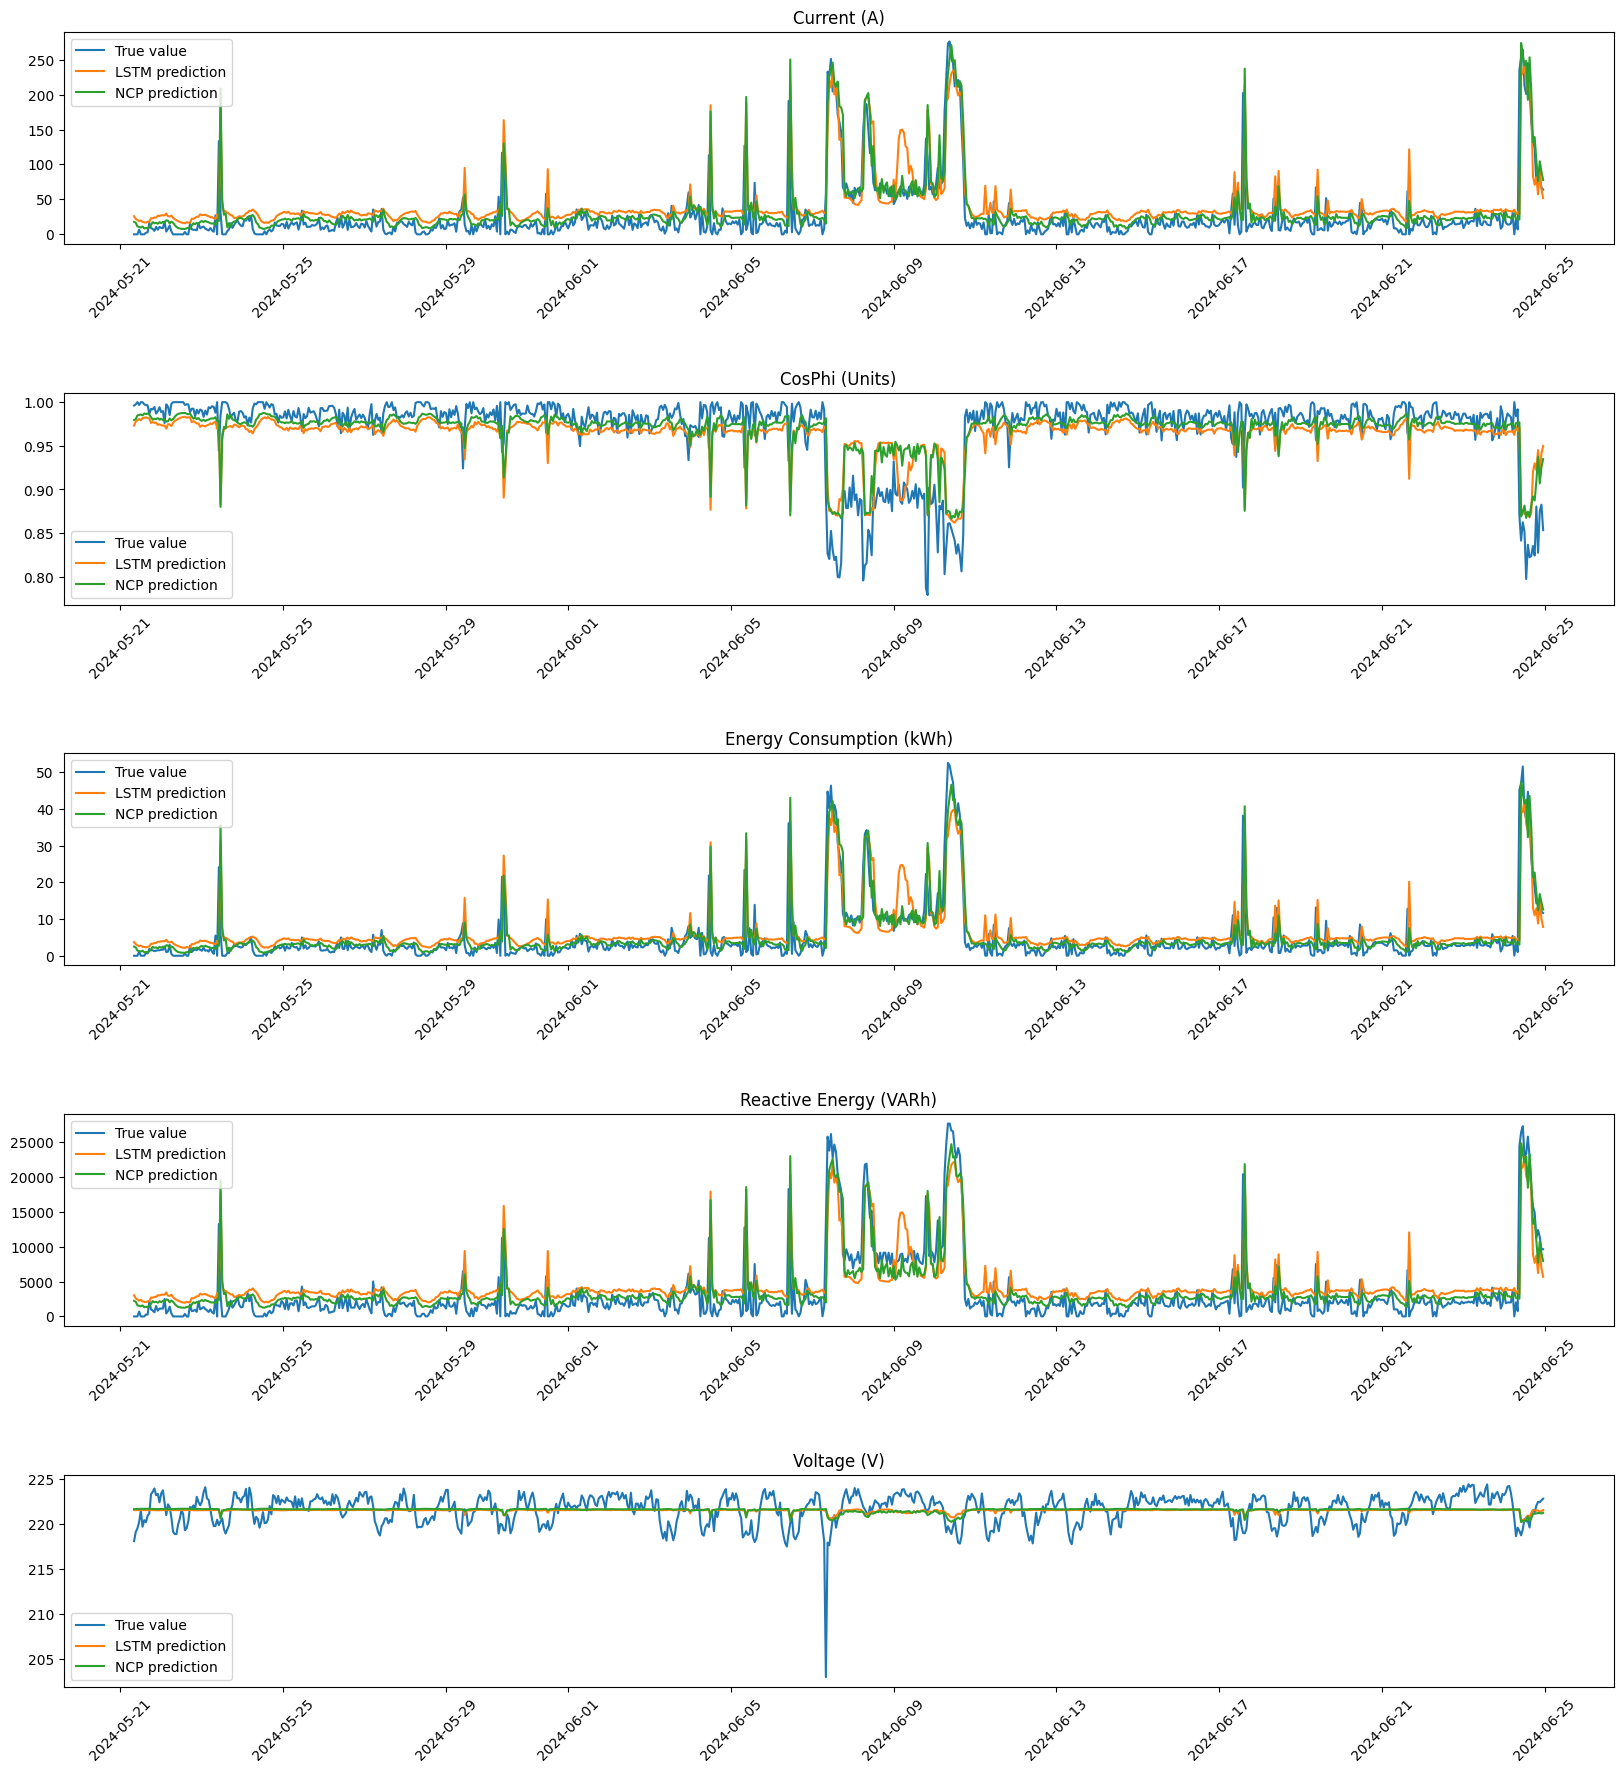

In [36]:
plt.figure(figsize=(20, 20))
plt.subplots_adjust(top=0.9375, hspace=0.7)

for i in range(len(data.columns)):
  plt.subplot(len(data.columns), 1, i + 1)
  plt.plot(timestamps[train_size+timesteps:], y_test_inverse[:, i], label='True value')
  plt.plot(timestamps[train_size+timesteps:], y_test_pred_lstm_inverse[:, i], label='LSTM prediction')
  plt.plot(timestamps[train_size+timesteps:], y_test_pred_ncp_inverse[:, i], label='NCP prediction')
  plt.xticks(rotation=45)
  plt.title(data.columns[i])
  plt.legend()
plt.subplots_adjust(hspace=0.7)
plt.show()

Compute and plot the normalized prediction error on the test set for each model.

In [37]:
y_test_err_lstm = y_test_pred_lstm - y_test
y_test_err_ncp = y_test_pred_ncp - y_test

/tmp/ipykernel_20476/1633205603.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


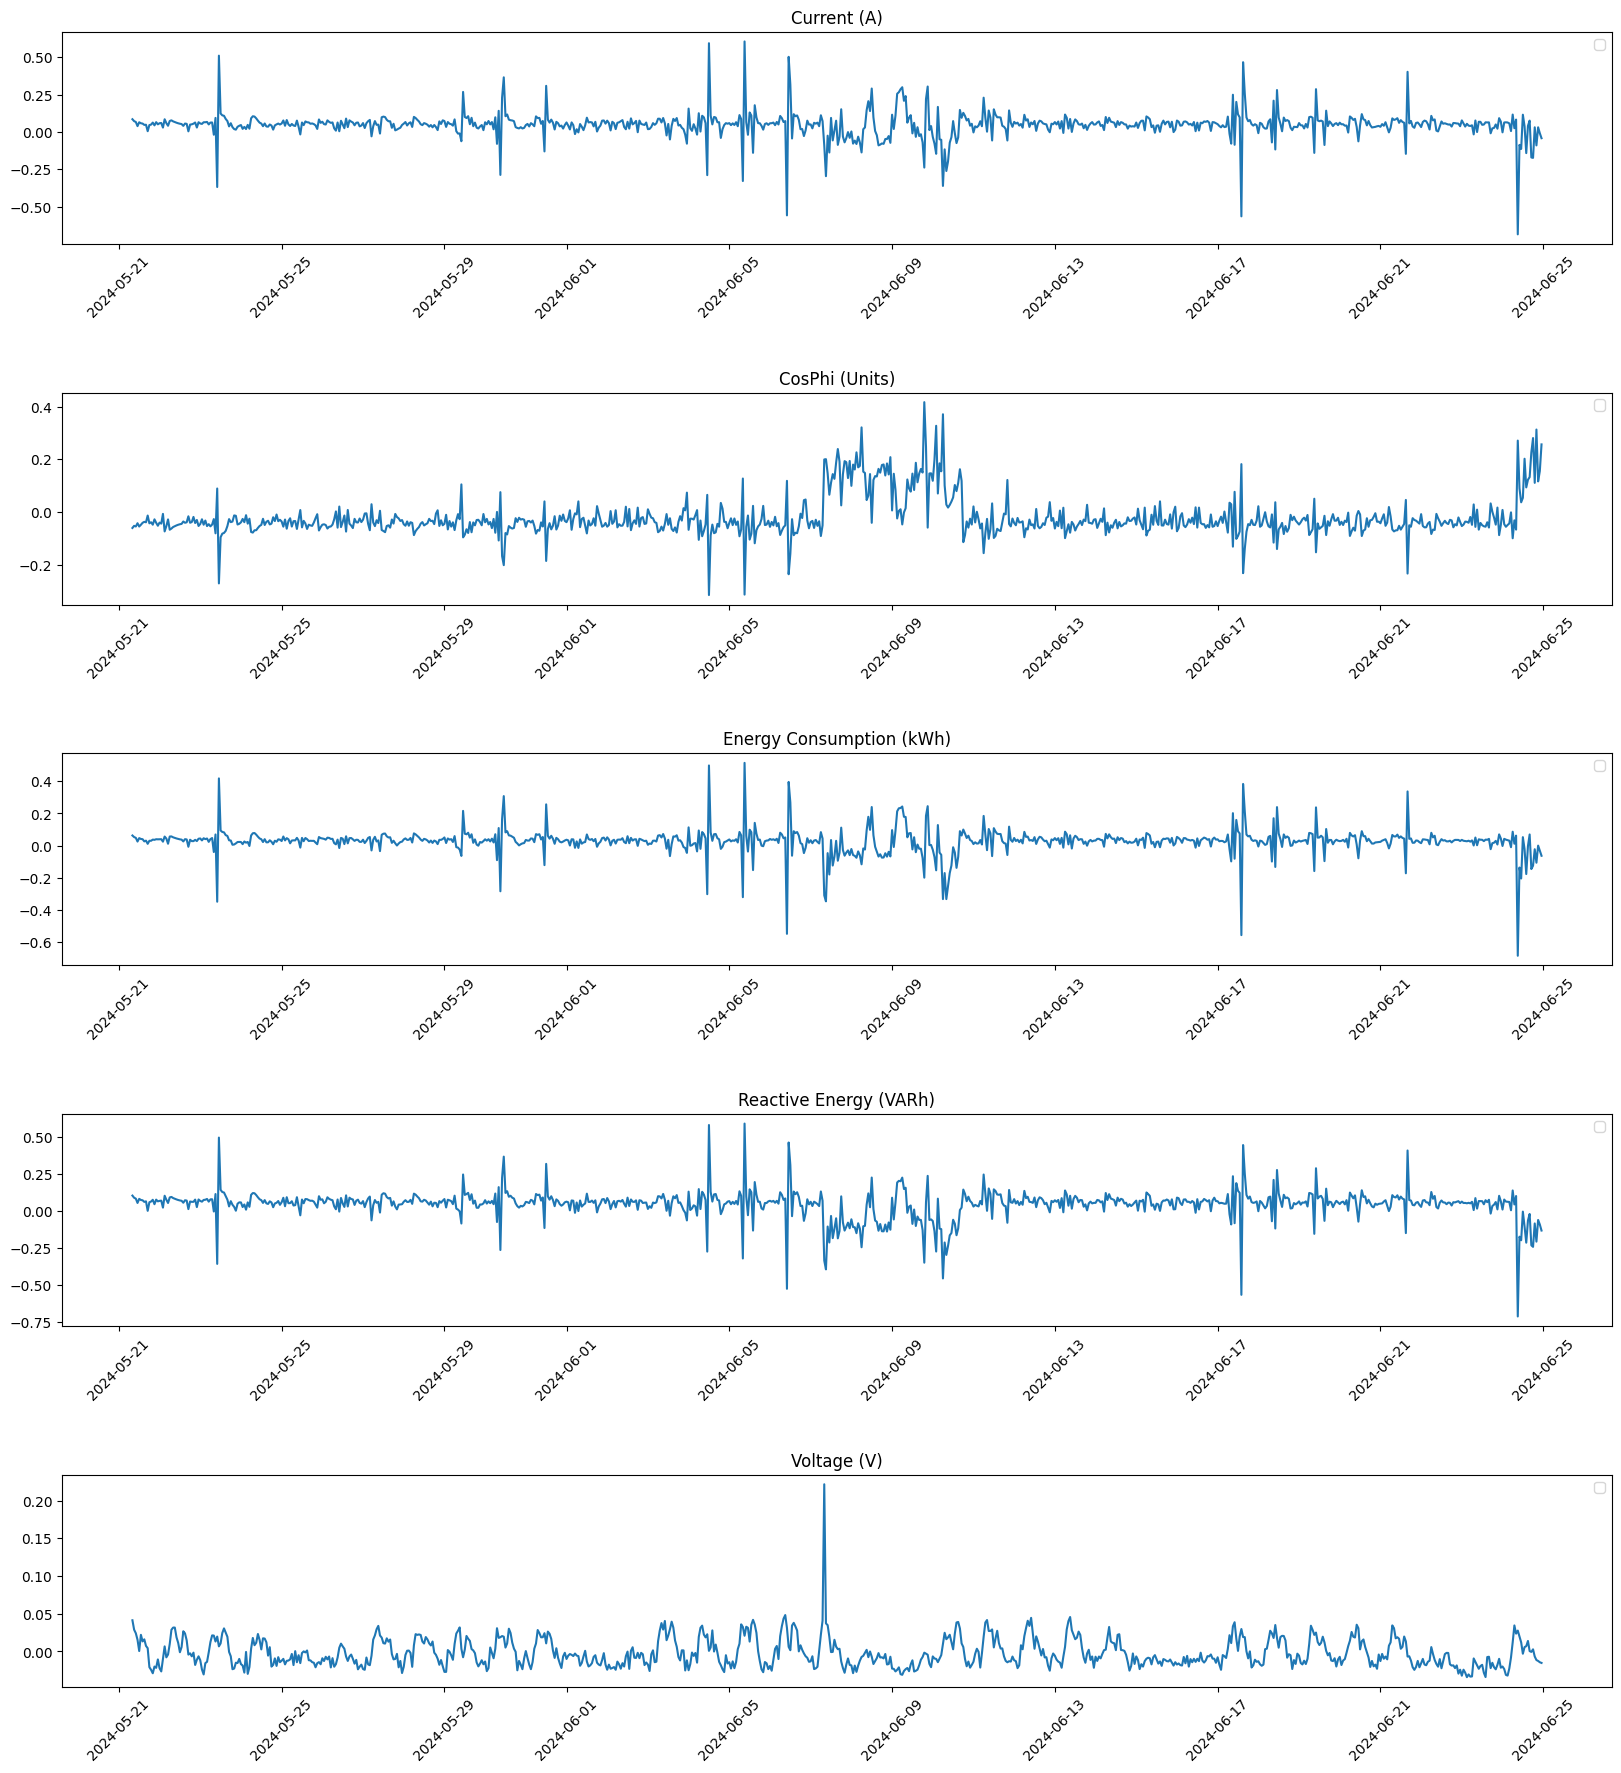

In [38]:
plt.figure(figsize=(20, 20))
plt.subplots_adjust(top=0.9375, hspace=0.7)

for i in range(len(data.columns)):
  plt.subplot(len(data.columns), 1, i + 1)
  plt.plot(timestamps[train_size+timesteps:], y_test_err_lstm[:, i])
  plt.xticks(rotation=45)
  plt.title(data.columns[i])
  plt.legend()
plt.subplots_adjust(hspace=0.7)
plt.show()

/tmp/ipykernel_20476/2071494343.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


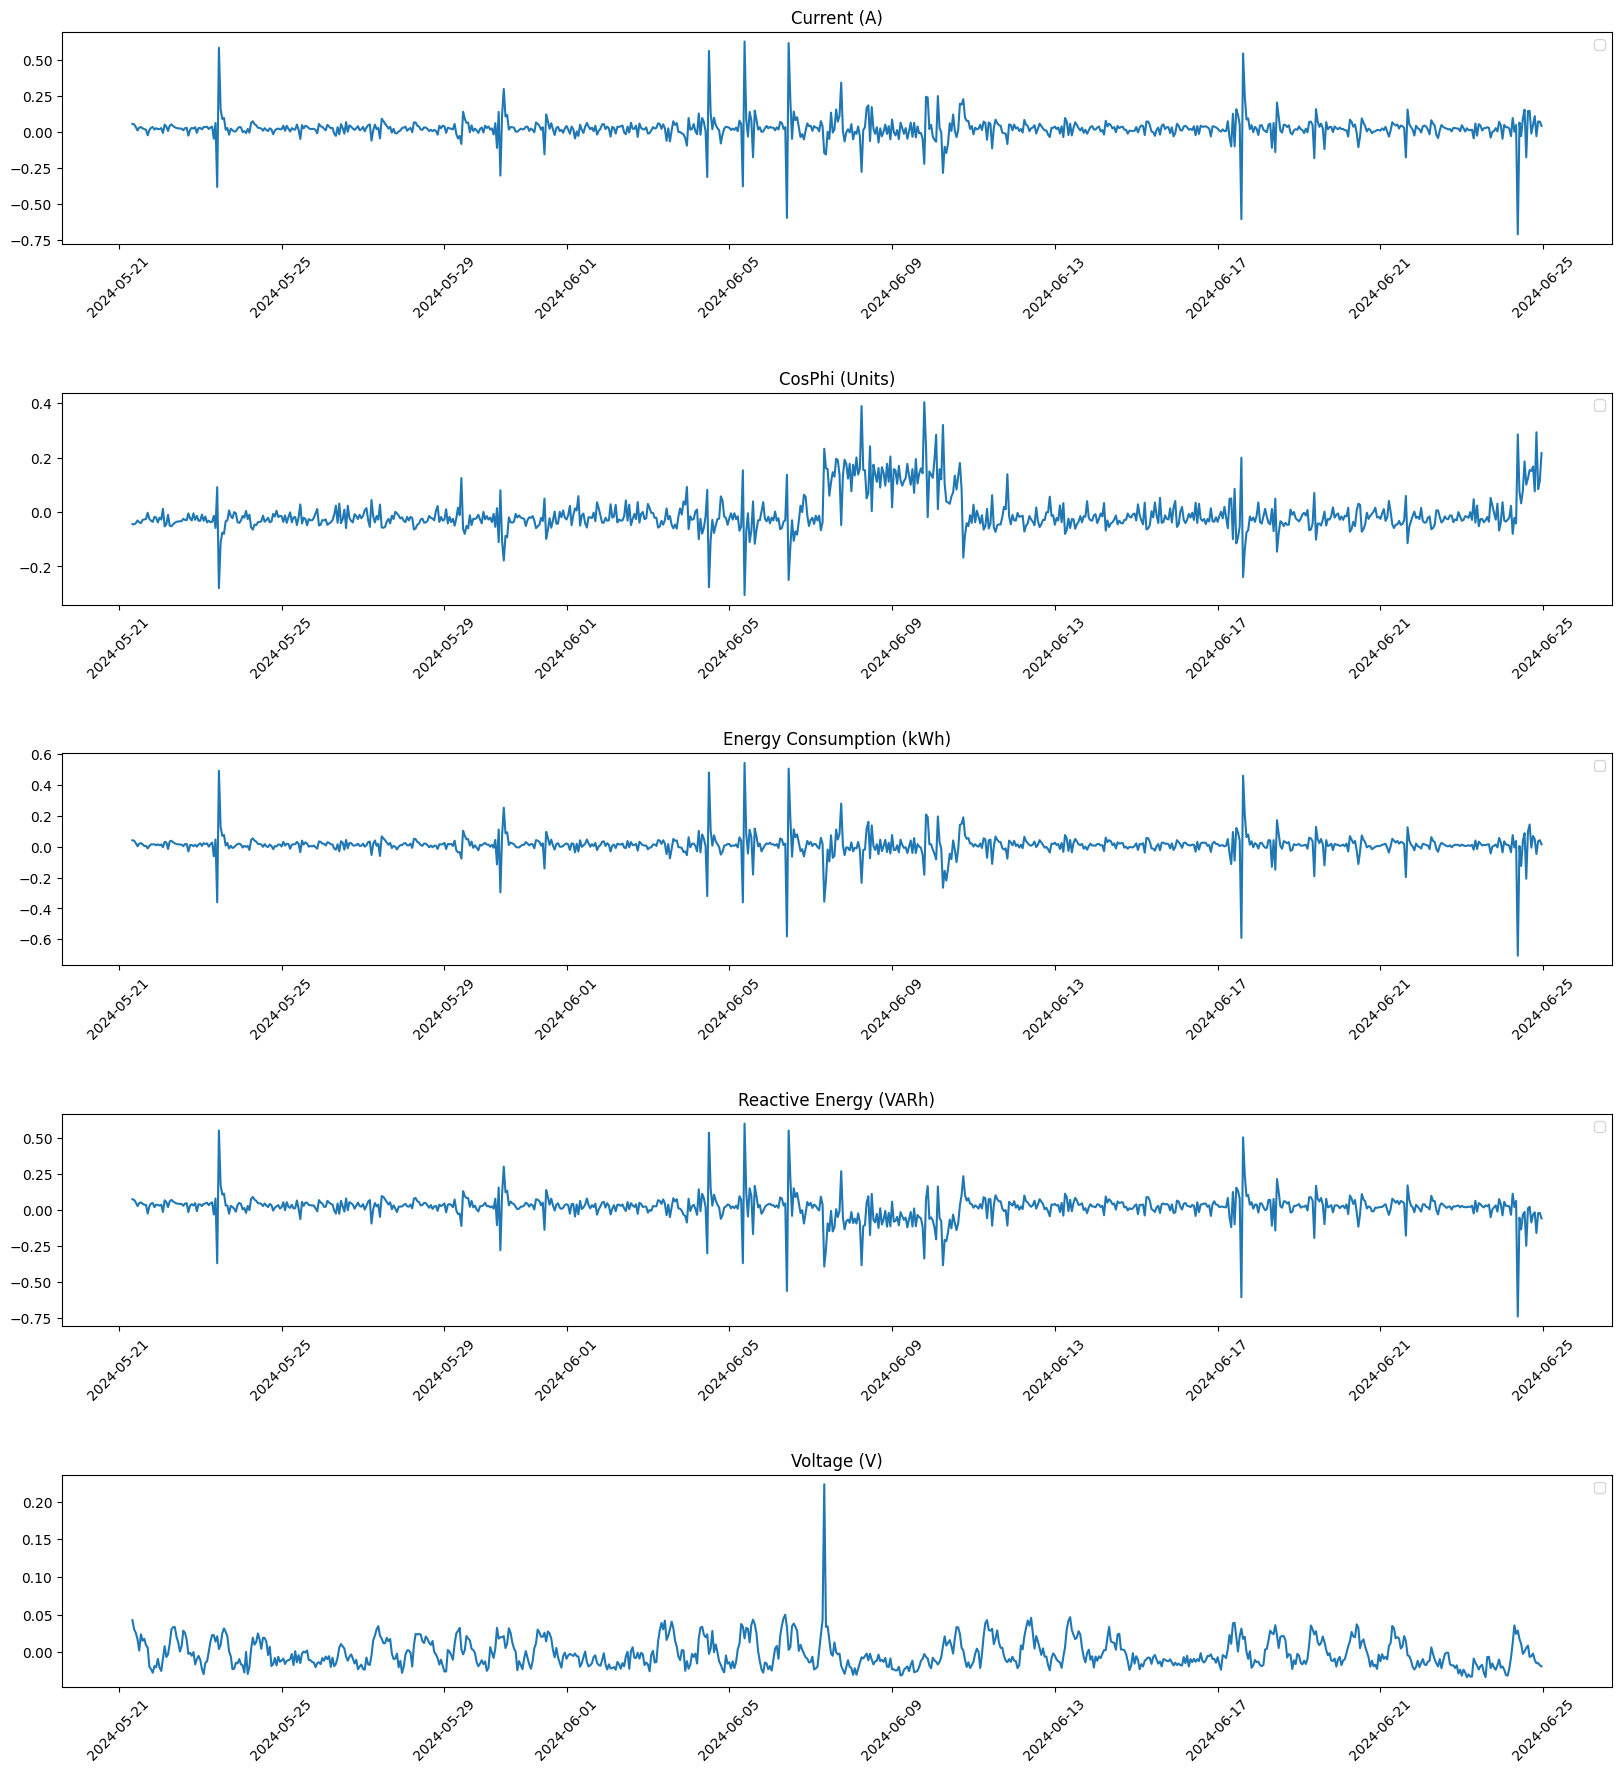

In [39]:
plt.figure(figsize=(20, 20))
plt.subplots_adjust(top=0.9375, hspace=0.7)

for i in range(len(data.columns)):
  plt.subplot(len(data.columns), 1, i + 1)
  plt.plot(timestamps[train_size+timesteps:], y_test_err_ncp[:, i])
  plt.xticks(rotation=45)
  plt.title(data.columns[i])
  plt.legend()
plt.subplots_adjust(hspace=0.7)
plt.show()

Mean Square Error (MSE) computation.

In [40]:
# MSEs for training set
mse_train_lstm = np.mean(np.square(y_train_pred_lstm - y_train), axis=0)
mse_train_ncp = np.mean(np.square(y_train_pred_ncp - y_train), axis=0)

# MSEs for test set
mse_test_lstm = np.mean(np.square(y_test_err_lstm), axis=0)
mse_test_ncp = np.mean(np.square(y_test_err_ncp), axis=0)

print("MSEs for training set\n--------------------------------")
for i in range(len(data.columns)):
  print(f"{data.columns[i]}: LSTM {mse_train_lstm[i]:.4f}, NCP {mse_train_ncp[i]:.4f}")
print("--------------------------------")
print(f"Average: LSTM {np.mean(mse_train_lstm):.4f}, NCP {np.mean(mse_train_ncp):.4f}")
print()

print("\nMSEs for test set\n--------------------------------")
for i in range(len(data.columns)):
  print(f"{data.columns[i]}: LSTM {mse_test_lstm[i]:.4f}, NCP {mse_test_ncp[i]:.4f}")
print("--------------------------------")
print(f"Average: LSTM {np.mean(mse_test_lstm):.4f}, NCP {np.mean(mse_test_ncp):.4f}")

MSEs for training set
--------------------------------
Current (A): LSTM 0.0114, NCP 0.0106
CosPhi (Units): LSTM 0.0047, NCP 0.0039
Energy Consumption (kWh): LSTM 0.0085, NCP 0.0083
Reactive Energy (VARh): LSTM 0.0127, NCP 0.0112
Voltage (V): LSTM 0.0009, NCP 0.0009
--------------------------------
Average: LSTM 0.0076, NCP 0.0070


MSEs for test set
--------------------------------
Current (A): LSTM 0.0102, NCP 0.0077
CosPhi (Units): LSTM 0.0061, NCP 0.0049
Energy Consumption (kWh): LSTM 0.0075, NCP 0.0060
Reactive Energy (VARh): LSTM 0.0117, NCP 0.0085
Voltage (V): LSTM 0.0004, NCP 0.0004
--------------------------------
Average: LSTM 0.0072, NCP 0.0055


Plot the computed MSEs in an histogram.

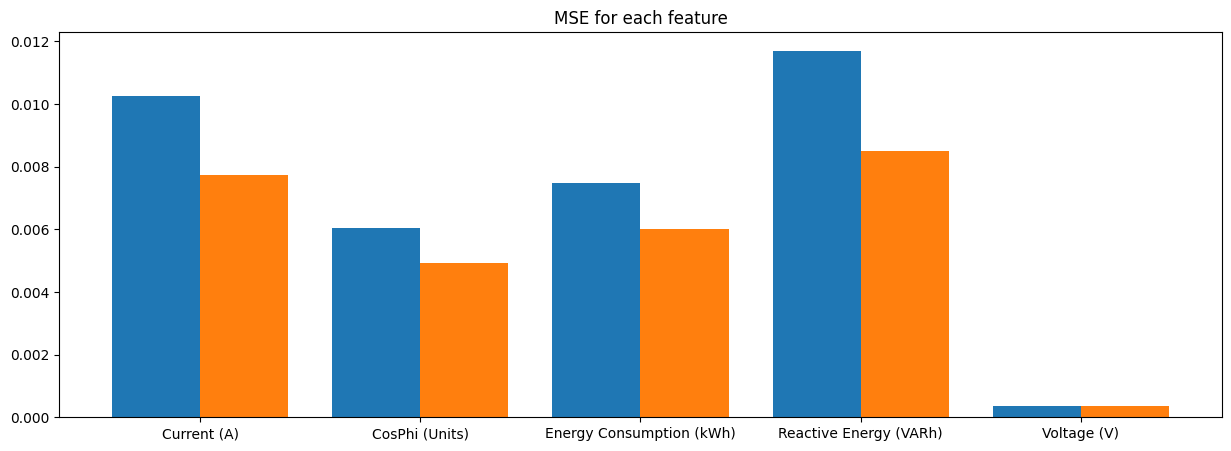

In [41]:
plt.figure(figsize=(15, 5))
plt.bar(np.arange(len(measurements)) - 0.2, mse_test_lstm, 0.4, label = 'LSTM') 
plt.bar(np.arange(len(measurements)) + 0.2, mse_test_ncp, 0.4, label = 'NCP') 
plt.xticks(np.arange(len(measurements)), measurements) 
plt.title("MSE for each feature")
plt.show() 